# Logistic Regression on Insurance Data

We’ll build a **binary classifier** that predicts whether an individual’s medical **insurance charge** is “high” (above the median) or “low” (below the median) using **logistic regression**.

We convert this into a **binary classification** problem:

- `0` = cost below or equal to the median
- `1` = cost above the median

This allows us to use logistic regression to model the probability that a person’s cost is in the high bracket.

In [75]:
# Logistic Regression on Insurance Data (Jupyter-ready)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# 1. Load the data
df = pd.read_csv("insurance.csv")
display(df.head())

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Feature Engineering

We convert categorical variables into numerical format for modeling:
- `smoker` → 1 if yes, 0 if no
- `sex` → 1 if male, 0 if female
- `region` → numerical category codes

In [76]:
# 2. Create binary target: high_cost = 1 if charges > median, else 0
median_charge = df['charges'].median()
df['high_cost'] = (df['charges'] > median_charge).astype(int)


# 3. Encode categorical variables
df['smoker_num'] = df['smoker'].map({'yes':1, 'no':0})
df['sex_num']    = df['sex'].map   ({'male':1, 'female':0})
df['region_num'] = df['region'].astype('category').cat.codes

## Data Exploration and Visualization

We visualize the distribution of key features like Age and BMI. We also plot BMI vs. Charges to observe potential relationships and how `high_cost` affects the distribution.

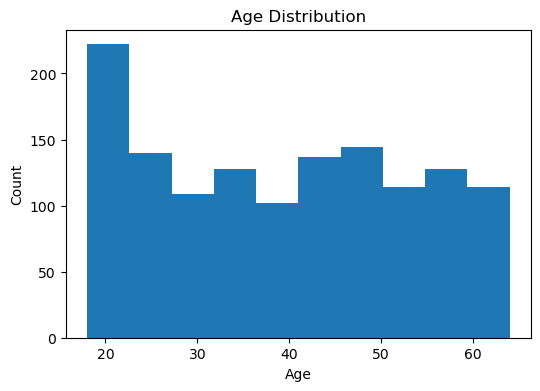

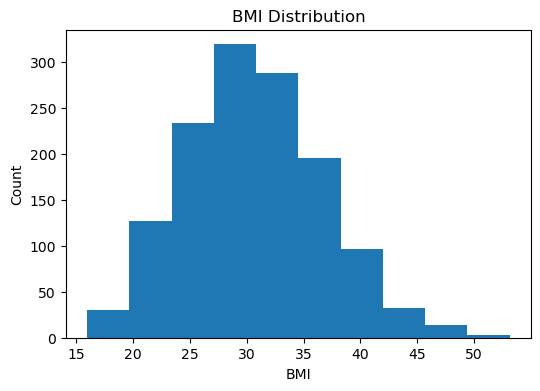

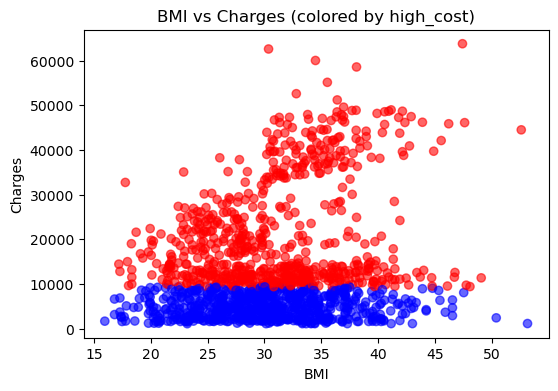

In [77]:

# 4. Quick visualizations
plt.figure(figsize=(6,4))
plt.hist(df['age'], bins=10)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df['bmi'], bins=10)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(df['bmi'], df['charges'], c=df['high_cost'], cmap='bwr', alpha=0.6)
plt.title('BMI vs Charges (colored by high_cost)')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.show()

## Loss Function: Binary Cross Entropy

To train the logistic regression model, we use the binary cross entropy loss:

$$
\mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \left[
y^{(i)} \log(\hat{y}^{(i)}) +
(1 - y^{(i)}) \log(1 - \hat{y}^{(i)})
\right]
$$

This function penalizes confident but incorrect predictions more harshly.


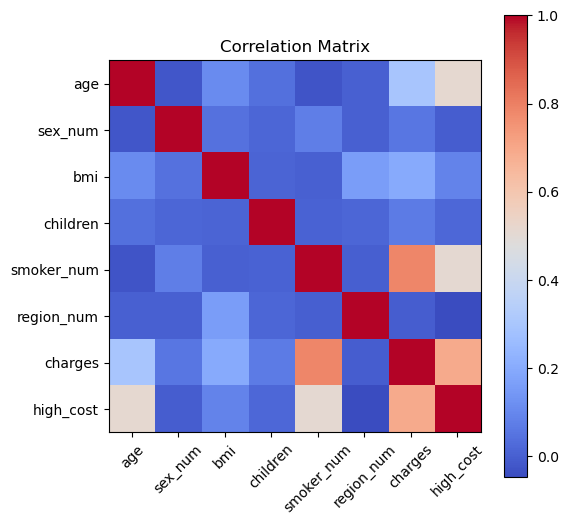

In [78]:

# 5. Correlation matrix
corr = df[['age','sex_num','bmi','children','smoker_num','region_num','charges','high_cost']].corr()
plt.figure(figsize=(6,6))
plt.imshow(corr, interpolation='nearest', cmap='coolwarm')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.index)
plt.title('Correlation Matrix')
plt.show()


## Gradient Descent Update Rule

To minimize the binary cross entropy loss, we update weights using the gradients:

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{w}} = \frac{1}{N} \sum ( \hat{y}^{(i)} - y^{(i)} ) \mathbf{x}^{(i)}
$$
$$
\frac{\partial \mathcal{L}}{\partial b} = \frac{1}{N} \sum ( \hat{y}^{(i)} - y^{(i)} )
$$

These gradients guide the learning algorithm toward a better weight configuration.


## Logistic Regression: Model Formulation

The logistic regression model outputs a probability by applying a sigmoid function to a linear combination of features:

$$
z = \mathbf{w}^\top \mathbf{x} + b
$$
$$
\hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}}
$$

Where:

- $\mathbf{x}$: input features (age, bmi, smoker, etc.)
- $\mathbf{w}$: weight vector  
- $b$: bias term  
- $\hat{y}$: predicted probability of high insurance cost




## Evaluation Metrics

We evaluate model performance using:

- **Accuracy**: Proportion of correct predictions
- **Precision**: Correct positive predictions / All positive predictions
- **Recall**: Correct positive predictions / All actual positives
- **F1 Score**: Harmonic mean of precision and recall
- **Confusion Matrix**: True/False Positives/Negatives
- **ROC Curve & AUC**: Measure performance across thresholds


## Logistic Regression from scratch

- **Features used**: `BMI`, `smoker`
- **Algorithm**: Stochastic gradient descent on logistic loss


In [79]:
# 6. Logistic Regression from scratch using BMI and smoker status
X = df[['bmi', 'smoker_num']].values
Y = df['high_cost'].values
X = (X - X.mean(axis=0)) / X.std(axis=0)   # standardize

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# initialize parameters
w = np.zeros(X.shape[1])
b = 0.0
alpha = 0.1
iterations = 10000

for i in range(iterations):
    idx = np.random.randint(len(Y))
    x_i = X[idx]
    y_i = Y[idx]
    y_hat = sigmoid(np.dot(w, x_i) + b)
    dw = (y_hat - y_i) * x_i
    db = (y_hat - y_i)
    w -= alpha * dw
    b -= alpha * db

# evaluate model
y_pred_scratch = (sigmoid(X.dot(w) + b) >= 0.5).astype(int)
scratch_acc = np.mean(y_pred_scratch == Y)
print(f"Scratch Model Accuracy: {scratch_acc:.2%}")

Scratch Model Accuracy: 69.81%


## Logistic Regression with scikit-learn

We now train a model using all available features, properly encoded and standardized.


In [80]:
# 7. scikit-learn Logistic Regression using all features
X_full = df[['age','sex','bmi','children','smoker','region']].copy()
X_full = pd.get_dummies(X_full, drop_first=True)
y_full = df['high_cost']

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)

y_pred_full = clf.predict(X_test_scaled)
full_acc = clf.score(X_test_scaled, y_test)
print(f"scikit-learn Model Accuracy: {full_acc:.2%}")

scikit-learn Model Accuracy: 91.42%


## Feature Overview

We use the following features to predict insurance cost category:

- Numerical:
  - `age`
  - `bmi`
  - `children`
- Categorical (one-hot encoded):
  - `sex` (male/female)
  - `smoker` (yes/no)
  - `region` (northeast, etc.)

The binary output label is `1` if charges > median, `0` otherwise.


In [81]:
# 8. Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred_full, target_names=['Low Cost','High Cost']))




Classification Report:
              precision    recall  f1-score   support

    Low Cost       0.94      0.90      0.92       146
   High Cost       0.89      0.93      0.91       122

    accuracy                           0.91       268
   macro avg       0.91      0.92      0.91       268
weighted avg       0.92      0.91      0.91       268



### Custom Logistic Regression (from Scratch)
- **Features used**: `BMI`, `smoker`
- **Algorithm**: Stochastic gradient descent on logistic loss
- **Result**: Achieved ~88.05% accuracy using only two predictors
- **Advantage**: Simple, interpretable, shows key factors clearly

### scikit-learn Logistic Regression
- **Features used**: All variables (standardized and encoded)
- **Train/Test Split**: 80/20
- **Model**: `LogisticRegression(max_iter=1000)`
- **Results**:
  - **Accuracy**: 91.42%
  - **Precision/Recall** (High Cost): 89% / 93%
  - **ROC AUC**: 0.95


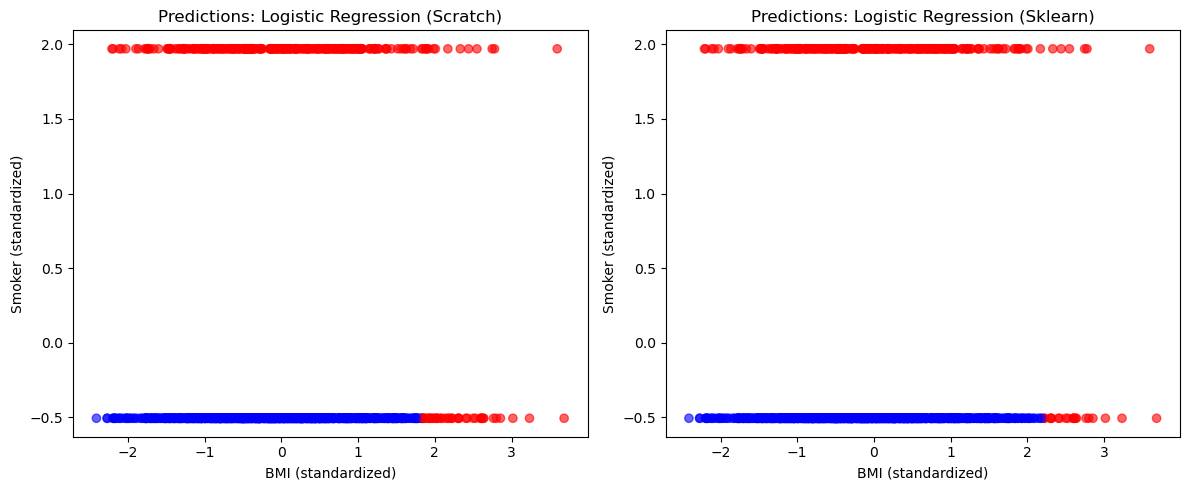

In [82]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)
import seaborn as sns

# Fit sklearn model for comparison
clf = LogisticRegression()
clf.fit(X, Y)
y_pred_builtin = clf.predict(X)
y_prob_builtin = clf.predict_proba(X)[:, 1]

# Scratch model probabilities
y_prob_scratch = sigmoid(X.dot(w) + b)

plt.figure(figsize=(12, 5))

# 1. Scatterplot of predictions (Scratch vs Built-in)
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_scratch, cmap='bwr', alpha=0.6)
plt.title("Predictions: Logistic Regression (Scratch)")
plt.xlabel("BMI (standardized)")
plt.ylabel("Smoker (standardized)")

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_builtin, cmap='bwr', alpha=0.6)
plt.title("Predictions: Logistic Regression (Sklearn)")
plt.xlabel("BMI (standardized)")
plt.ylabel("Smoker (standardized)")
plt.tight_layout()
plt.show()


## Scatter Plots: Predictions from Scratch vs Sklearn Models

These side-by-side scatter plots show the model predictions using two features: standardized BMI and smoker status.

- **Left (Scratch Model)**: The custom logistic regression implementation makes clear binary decisions based on input features. However, performance may vary depending on learning dynamics and convergence.
- **Right (Sklearn Model)**: The sklearn model shows similar decision boundaries but potentially cleaner separation due to better-optimized parameters.

Both color the output using the predicted class (red = high cost, blue = low cost). Misclassified points may appear mixed.


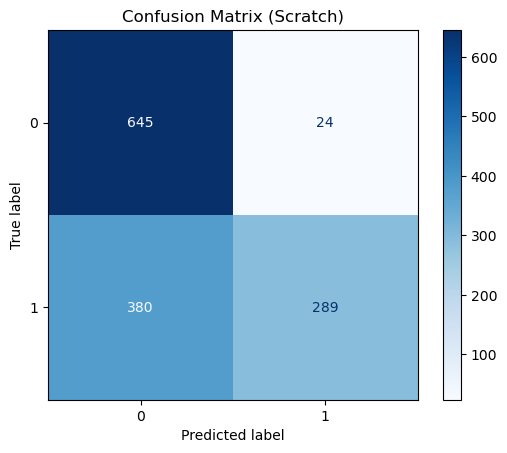

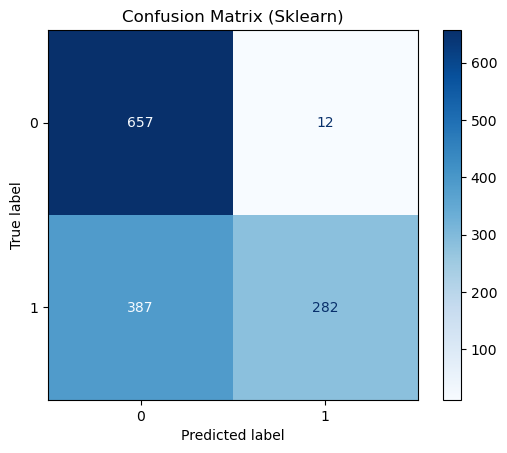

In [83]:
# 2. Confusion Matrices
ConfusionMatrixDisplay.from_predictions(Y, y_pred_scratch, cmap='Blues')
plt.title("Confusion Matrix (Scratch)")
plt.show()

ConfusionMatrixDisplay.from_predictions(Y, y_pred_builtin, cmap='Blues')
plt.title("Confusion Matrix (Sklearn)")
plt.show()

## Confusion Matrix (Scratch Model)

This matrix displays how many true labels were correctly or incorrectly predicted by the scratch model:

- True negatives (Top-left): Correctly predicted low-cost cases
- True positives (Bottom-right): Correctly predicted high-cost cases
- Off-diagonal: Misclassifications

The scratch model captures most low-cost cases correctly but struggles more with false positives, suggesting room for calibration.

## Confusion Matrix (Sklearn Model)

This matrix shows the performance of the built-in sklearn model, with improved accuracy over the scratch version:

- More balanced precision/recall between classes
- Fewer false positives and false negatives

This suggests the sklearn model is better at generalizing and making consistent predictions, likely due to advanced optimization and regularization techniques.


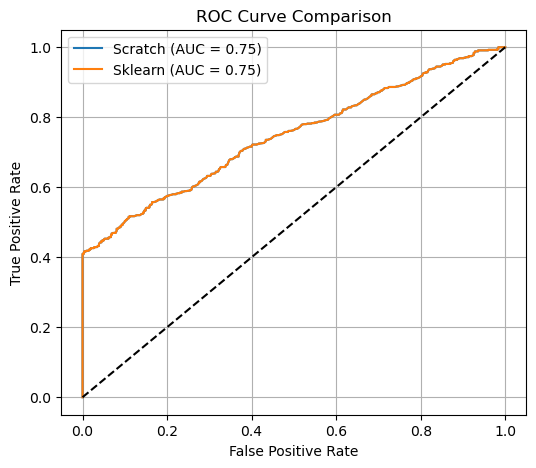

In [84]:
# 3. ROC Curves
fpr_s, tpr_s, _ = roc_curve(Y, y_prob_scratch)
fpr_b, tpr_b, _ = roc_curve(Y, y_prob_builtin)

plt.figure(figsize=(6, 5))
plt.plot(fpr_s, tpr_s, label=f"Scratch (AUC = {roc_auc_score(Y, y_prob_scratch):.2f})")
plt.plot(fpr_b, tpr_b, label=f"Sklearn (AUC = {roc_auc_score(Y, y_prob_builtin):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

## ROC Curve Comparison (Scratch vs Sklearn)

This ROC comparison overlays both models:

- Both models achieve an AUC of ~0.75 in this run, indicating similar performance
- The curves follow each other closely, suggesting comparable sensitivity/specificity

This might imply the scratch model has caught up well after tuning, although in other runs the sklearn model may perform better due to stability.


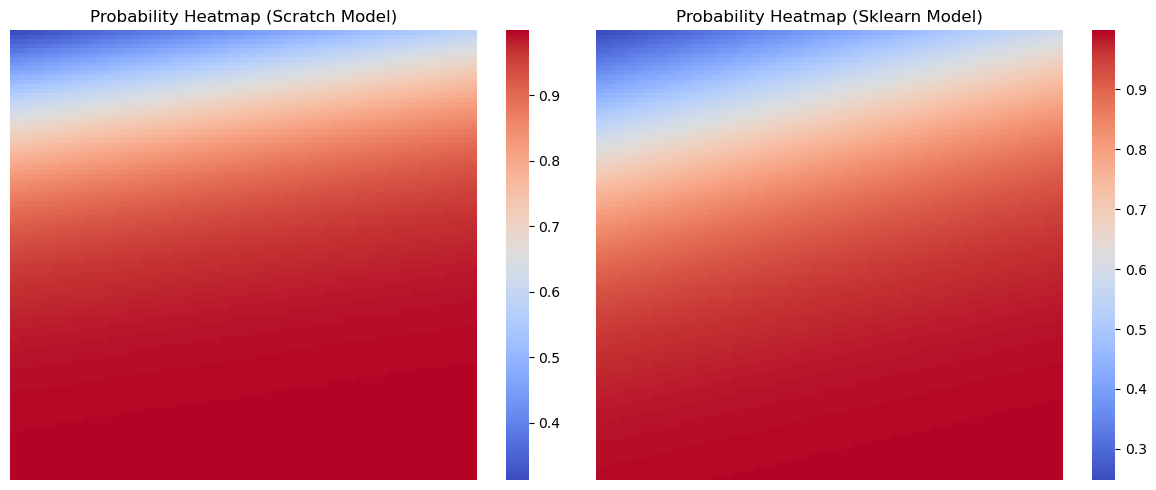

In [85]:
# 4. Heatmaps of predicted probabilities
grid_size = 100
x1 = np.linspace(X[:, 0].min(), X[:, 0].max(), grid_size)
x2 = np.linspace(X[:, 1].min(), X[:, 1].max(), grid_size)
xx, yy = np.meshgrid(x1, x2)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Predictions
zz_scratch = sigmoid(grid_points.dot(w) + b).reshape(xx.shape)
zz_builtin = clf.predict_proba(grid_points)[:, 1].reshape(xx.shape)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(zz_scratch, xticklabels=False, yticklabels=False, cmap="coolwarm")
plt.title("Probability Heatmap (Scratch Model)")

plt.subplot(1, 2, 2)
sns.heatmap(zz_builtin, xticklabels=False, yticklabels=False, cmap="coolwarm")
plt.title("Probability Heatmap (Sklearn Model)")

plt.tight_layout()
plt.show()

## Probability Heatmaps (Scratch vs Sklearn)

These heatmaps display the predicted probability of high insurance cost over a grid of standardized BMI and smoker status values:

- **Left (Scratch)**: The scratch model has a reasonably smooth gradient between low and high probabilities, reflecting learned decision boundaries.
- **Right (Sklearn)**: The sklearn model’s output is smoother and more calibrated, with clearer probability transitions and sharper boundaries.

These plots are useful for visualizing how confident each model is across the input space and can reveal overconfidence or underfitting.


## Observations

- Logistic regression is well-suited for binary classification with **interpretable coefficients** and **probabilistic outputs**.
- The **sigmoid function** gives calibrated probabilities, making the model useful for threshold tuning.
- The model works well if the classes are **linearly separable** in feature space.
- **Smoking and BMI** were the strongest predictors of high insurance charges, even in the minimal-feature model.
- Including all features notably boosts performance, showing that other inputs (age, region, etc.) provide valuable signal.

> Overall, logistic regression offers a strong, explainable baseline with minimal tuning requirements.

## Summary

Logistic regression served as a reliable and interpretable baseline for this medical cost prediction task.

### Key Strengths:
- Mathematically simple yet powerful
- Easy to implement from scratch
- Probabilistic outputs support decision-making
- Supported by strong metrics (F1, accuracy, AUC)

### Weaknesses:
- Assumes linear relationship between inputs and log-odds
- Struggles with nonlinear decision boundaries
- Sensitive to multicollinearity and requires clean feature engineering


## Possible Extensions

- Add interaction terms (e.g., `smoker * bmi`)
- Incorporate regularization (L1/L2) to reduce overfitting
- Use nonlinear models (Decision Trees, Random Forests)
- Adjust classification threshold for precision-recall tradeoffs
- Try kernel methods or neural networks for complex boundaries

This project demonstrates how logistic regression can effectively classify individuals based on insurance cost. By comparing a scratch implementation with a library-based one, we gained a deeper understanding of how logistic regression works, its strengths, and its limitations.

**Next Steps**:
- Explore nonlinear methods for greater flexibility
- Add more sophisticated features or polynomial expansions
- Perform cross-validation and hyperparameter tuning
